# Loading the data and exploring its shape and values

This notebook is Part 2 of my analysis of the ECG Hearbeat dataset.  In this version I'll be focusing on building Deep Learning models compared to the original version which I tried to use "standard" machine leraning models to establish a baseline for whether its worth it to use Deep Learning or not.

The baseline version can be found [here](https://www.kaggle.com/basharalkuwaiti/ecg-heartbeat-categorization-baseline)

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [47]:
mit_test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)
mit_train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
ptb_abnormal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv', header=None)
ptb_normal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_normal.csv', header=None)

In [48]:
mit_test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
mit_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
ptb_abnormal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [51]:
ptb_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
mit_test.rename(columns={187:"Class"}, inplace=True)
mit_train.rename(columns={187:"Class"}, inplace=True)
ptb_abnormal.rename(columns={187:"Class"}, inplace=True)
ptb_normal.rename(columns={187:"Class"}, inplace=True)

Looking at how many classes are there in each dataset
The MIT dataset has 5 clases:
* 0 = N  (Normal Beat)
* 1 = S  (Supraventricular premature beat)
* 2 = V  (Premature ventricular contraction)
* 3 = F  (Fusion of ventricular and normal beat)
* 4 = Q  (Unclassifiable beat)

Compared to the PTB dataset which is 1 for abnormal and 0 for normal


In [53]:
print ("MIT Train classes: \n", mit_train["Class"].value_counts())
print ("\nMIT Test classes: \n", mit_test["Class"].value_counts())
print ("\nPTB Abnormal classes: \n", ptb_abnormal["Class"].value_counts())
print ("\nPTB Normal classes: \n", ptb_normal["Class"].value_counts())

MIT Train classes: 
 0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: Class, dtype: int64

MIT Test classes: 
 0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: Class, dtype: int64

PTB Abnormal classes: 
 1.0    10506
Name: Class, dtype: int64

PTB Normal classes: 
 0.0    4046
Name: Class, dtype: int64


In [54]:
# Setting Dictionary to define the type of Heartbeat for both datasets
MIT_Outcome = {0. : 'Normal Beat',
               1. : 'Supraventricular premature beat',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular and normal beat',
               4. : 'Unclassifiable beat'}
PTB_Outcome = {0. : 'Normal',
               1. : 'Abnormal'}

# Generating Plots of some of the samples in the dataset

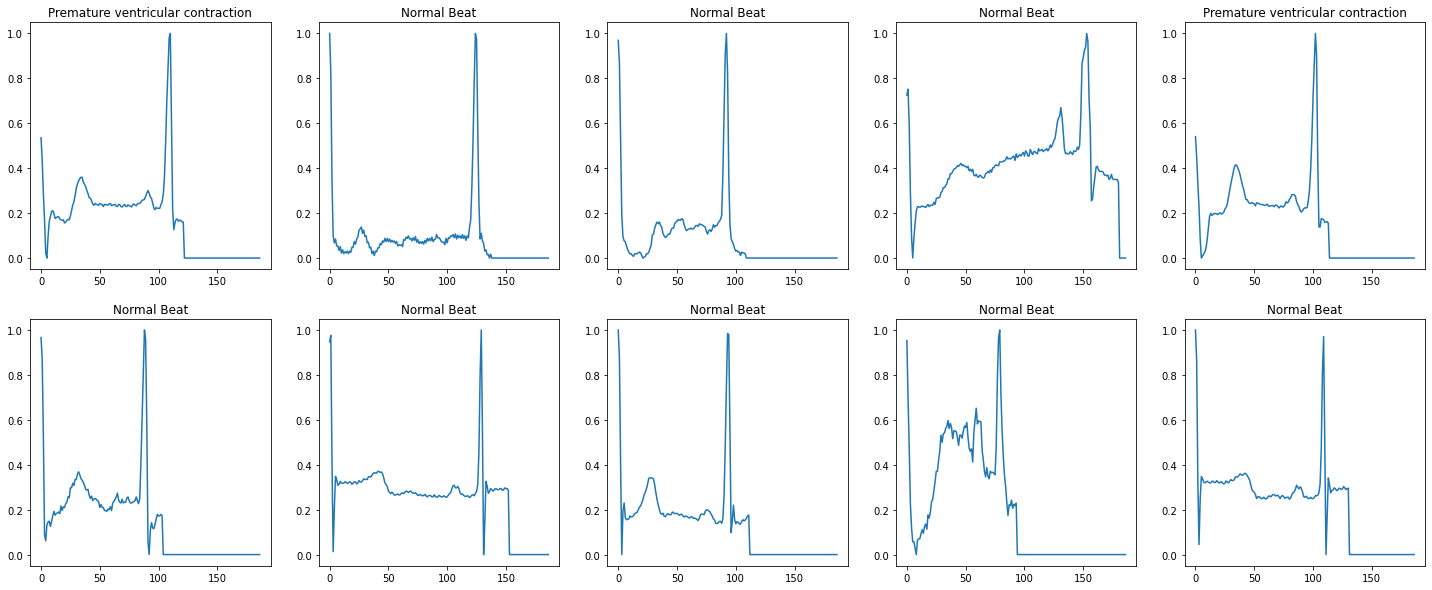

In [55]:
#Plotting 10 random samples from the MIT training dataset with their classification
plt.figure(figsize=(25,10))
np_count = np.linspace(0,186,187)
np_time = np.tile(np_count,(10,1))
rnd = np.random.randint(0,mit_train.shape[0],size=(10,))


for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    ax.plot(mit_train.iloc[rnd[i],np_time[i,:]])
    ax.set_title(MIT_Outcome[mit_train.loc[rnd[i],'Class']])

plt.show()


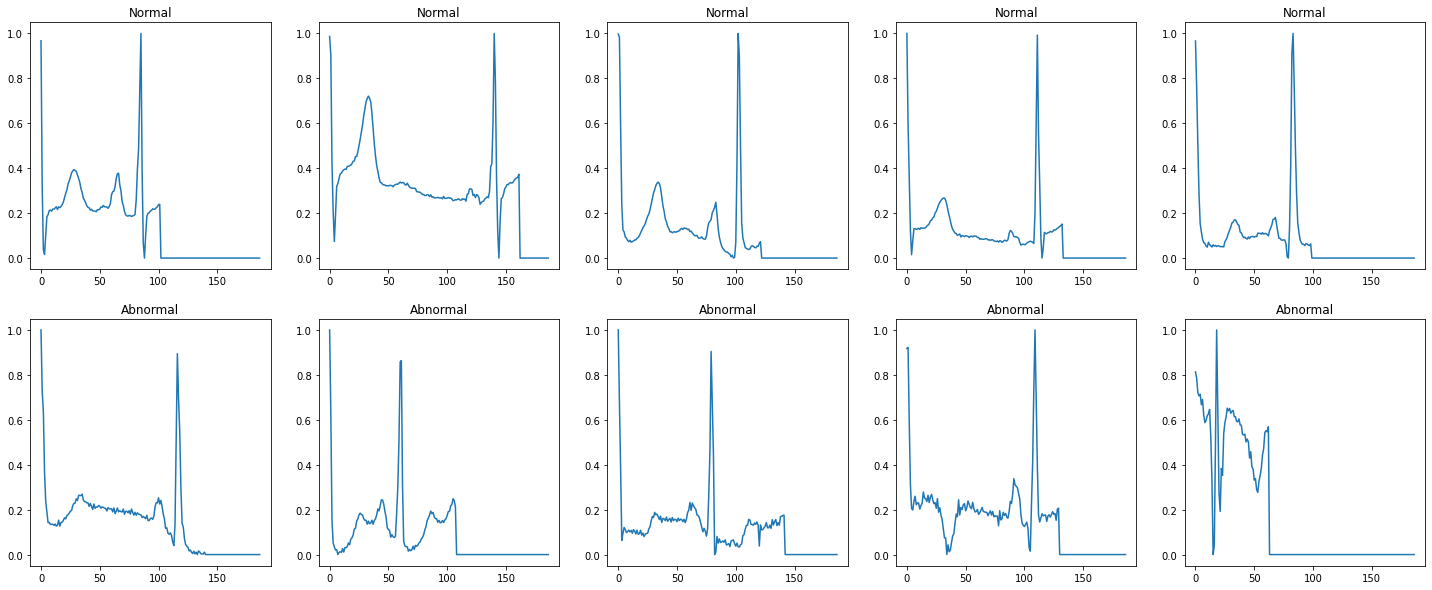

In [56]:
#Plotting 10 random samples from the PTB training dataset with their classification
plt.figure(figsize=(25,10))
rnd = np.random.randint(0,ptb_normal.shape[0],size=(5,))
rnd1 = np.random.randint(0,ptb_abnormal.shape[0], size=(5,))


for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    if (i < 5):
        ax.plot(ptb_normal.iloc[rnd[i],np_time[i,:]])
        ax.set_title(PTB_Outcome[ptb_normal.loc[rnd[i],'Class']])
    else:
        ax.plot(ptb_abnormal.iloc[rnd1[i-5],np_time[i,:]])
        ax.set_title(PTB_Outcome[ptb_abnormal.loc[rnd1[i-5],'Class']])

plt.show()

# Deep Learning Analysis

This is the where the notebooks are different.  Tha analysis above is similar to the [Baseline](https://www.kaggle.com/basharalkuwaiti/ecg-heartbeat-categorization-baseline) version

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence

In [58]:
#Preparing the training, validation and test sets for the PTB Data set
ptb_full = pd.concat([ptb_normal, ptb_abnormal], axis=0).sample(frac=1)
ptb_full = ptb_full.apply(np.random.permutation)
learn_ptb, test_ptb, out_learn_ptb, out_test_ptb = train_test_split(ptb_full.iloc[:,:187], ptb_full.iloc[:,-1], test_size=0.15, random_state=42)
train_ptb, valid_ptb, out_train_ptb, out_valid_ptb = train_test_split(learn_ptb, out_learn_ptb, test_size=0.2, random_state=42 )

In [59]:
print("Traing dataset size: ", train_ptb.shape)
print("Validation dataset size: ", valid_ptb.shape)
print("Test dataset size: ", test_ptb.shape)

Traing dataset size:  (9895, 187)
Validation dataset size:  (2474, 187)
Test dataset size:  (2183, 187)


In [60]:
#Normalizing the training & test data 
train_ptb = normalize(train_ptb, axis=0, norm='max')
valid_ptb = normalize(valid_ptb, axis=0, norm='max')
test_ptb = normalize(test_ptb, axis=0, norm='max')

In [61]:
max_length = 15
x_train_ptb = train_ptb.reshape(len(train_ptb),train_ptb.shape[1],1)
x_valid_ptb = valid_ptb.reshape(len(valid_ptb),valid_ptb.shape[1],1)
x_test_ptb = test_ptb.reshape(len(test_ptb),test_ptb.shape[1],1)

In [62]:
#Function to build Convolutional 1D Networks
def build_conv1d_model (n_hidden=1, n_neurons=512, dropout=0.5, input_shape=(x_train_ptb.shape[1],1)):
    orig_neurons = n_neurons
    model = keras.models.Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Conv1D(n_neurons,7, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPool1D(5))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae", "accuracy"])
    return model

In [63]:
checkpoint_cb = ModelCheckpoint("conv1d_ptb.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model = build_conv1d_model(n_neurons = 512, n_hidden=3, input_shape=(x_train_ptb.shape[1], x_train_ptb.shape[2]))
history = model.fit(x_train_ptb, out_train_ptb, epochs=20, validation_data=(x_valid_ptb, out_valid_ptb),  callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20
310/310 [==============================] - 5s 13ms/step - loss: 0.7460 - mae: 0.4100 - accuracy: 0.6695 - val_loss: 1.7645 - val_mae: 0.2822 - val_accuracy: 0.7187
Epoch 2/20
310/310 [==============================] - 4s 13ms/step - loss: 0.6065 - mae: 0.4122 - accuracy: 0.7218 - val_loss: 0.8056 - val_mae: 0.3352 - val_accuracy: 0.7187
Epoch 3/20
310/310 [==============================] - 4s 13ms/step - loss: 0.5902 - mae: 0.3983 - accuracy: 0.7296 - val_loss: 0.5947 - val_mae: 0.4113 - val_accuracy: 0.7187
Epoch 4/20
310/310 [==============================] - 4s 14ms/step - loss: 0.5896 - mae: 0.4032 - accuracy: 0.7251 - val_loss: 0.5942 - val_mae: 0.4073 - val_accuracy: 0.7187
Epoch 5/20
310/310 [==============================] - 4s 12ms/step - loss: 0.5885 - mae: 0.3998 - accuracy: 0.7271 - val_loss: 0.5944 - val_mae: 0.4078 - val_accuracy: 0.7187
Epoch 6/20
310/310 [==============================] - 4s 12ms/step - loss: 0.5949 - mae: 0.4040 - accuracy: 0.7219 - val_loss

In [64]:
model.evaluate(x_test_ptb,out_test_ptb)

69/69 [==============================] - 0s 5ms/step - loss: 0.5928 - mae: 0.4074 - accuracy: 0.7206


[0.5928419232368469, 0.40735098719596863, 0.7205680012702942]

In [65]:
conv1d_pred_ptb = model.predict (x_test_ptb)
conv1d_pred_ptb = np.rint(conv1d_pred_ptb.reshape(len(conv1d_pred_ptb)))

print(classification_report(out_test_ptb, conv1d_pred_ptb, target_names=[PTB_Outcome[i] for i in PTB_Outcome]))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       610
    Abnormal       0.72      1.00      0.84      1573

    accuracy                           0.72      2183
   macro avg       0.36      0.50      0.42      2183
weighted avg       0.52      0.72      0.60      2183



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
def build_LSTM_model (n_hidden=1, n_neurons=512, dropout=0.5, input_shape=(x_train_ptb.shape[1],1)):
    orig_neurons = n_neurons
    model = keras.models.Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Bidirectional(LSTM(n_neurons, return_sequences=True, dropout=dropout, recurrent_dropout = dropout)))
    model.add(Bidirectional(LSTM(n_neurons, dropout=dropout, recurrent_dropout=dropout)))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae", "accuracy"])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("lstm_ptb.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model = build_LSTM_model(n_neurons = 128, n_hidden=2, dropout=0.2, input_shape=(x_train_ptb.shape[1], x_train_ptb.shape[2]))
history = model.fit(x_train_ptb, out_train_ptb, epochs=20, validation_data=(x_valid_ptb, out_valid_ptb),  callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20
298/310 [===========================>..] - ETA: 44s - loss: 0.6125 - mae: 0.4185 - accuracy: 0.7078

In [ ]:
model.evaluate(x_test_ptb,out_test_ptb)

In [ ]:
LSTM_pred_ptb = model.predict (x_test_ptb)
LSTM_pred_ptb = np.rint(LSTM_pred_ptb.reshape(len(LSTM_pred_ptb)))

print(classification_report(out_test_ptb, LSTM_pred_ptb, target_names=[PTB_Outcome[i] for i in PTB_Outcome]))

In [82]:
LSTM_pred_ptb[0]

array([[0.71702534],
       [0.7187729 ],
       [0.7200541 ],
       [0.72100335],
       [0.72170174],
       [0.72221047],
       [0.7225521 ],
       [0.7228239 ],
       [0.72300035],
       [0.7231662 ],
       [0.7233183 ],
       [0.7234399 ],
       [0.7235558 ],
       [0.7236754 ],
       [0.7237895 ],
       [0.7238698 ],
       [0.7239485 ],
       [0.7240038 ],
       [0.7240092 ],
       [0.7240344 ],
       [0.7240649 ],
       [0.7240943 ],
       [0.72413665],
       [0.7241784 ],
       [0.7242317 ],
       [0.72426456],
       [0.7242907 ],
       [0.7242881 ],
       [0.72427267],
       [0.72423273],
       [0.7242006 ],
       [0.724156  ],
       [0.7240925 ],
       [0.72404236],
       [0.7239903 ],
       [0.72396797],
       [0.7239659 ],
       [0.7239985 ],
       [0.7240506 ],
       [0.72410774],
       [0.72414994],
       [0.7241682 ],
       [0.7241866 ],
       [0.72417396],
       [0.7241302 ],
       [0.72409767],
       [0.7240638 ],
       [0.724